In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tf_keras
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

2025-04-15 21:24:31.543053: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 21:24:31.779375: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 21:24:31.967370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744732472.136166    5781 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744732472.180574    5781 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744732472.561895    5781 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Download a dataset

In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[:90%]'],
    with_info=True,
    as_supervised=True
)

2025-04-15 21:24:40.198576: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


2025-04-15 21:24:40.459990: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-15 21:24:40.512805: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


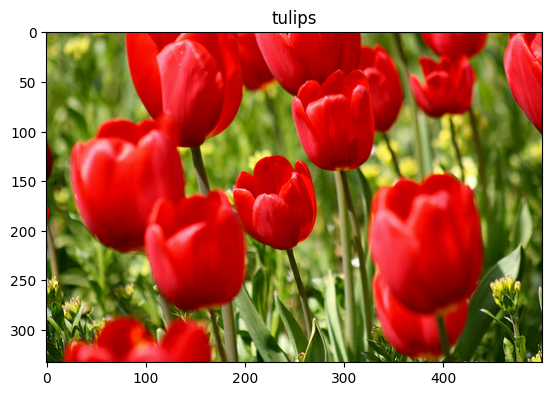

In [5]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

### Use Keras preprocessing layers

##### Resizing and rescaling

In [6]:
IMG_SIZE = 100

resize_and_rescale = tf_keras.Sequential([
    tf_keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf_keras.layers.Rescaling(1./255)
])

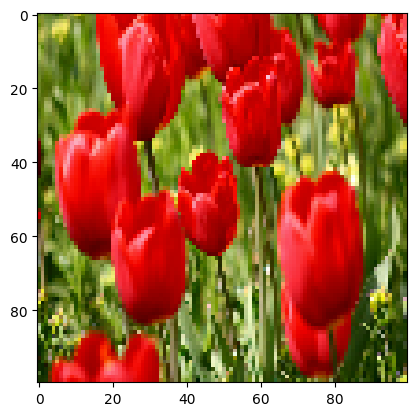

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [8]:
print("Min and max pixel values: ", result.numpy().min(), result.numpy().max())

Min and max pixel values:  0.0 1.0


##### Data augmentation

In [9]:
data_augmentation = tf_keras.Sequential([
    tf_keras.layers.RandomFlip("horizontal_and_vertical"),
    tf_keras.layers.RandomRotation(0.2)
])

In [10]:
# Add the image to a batch
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

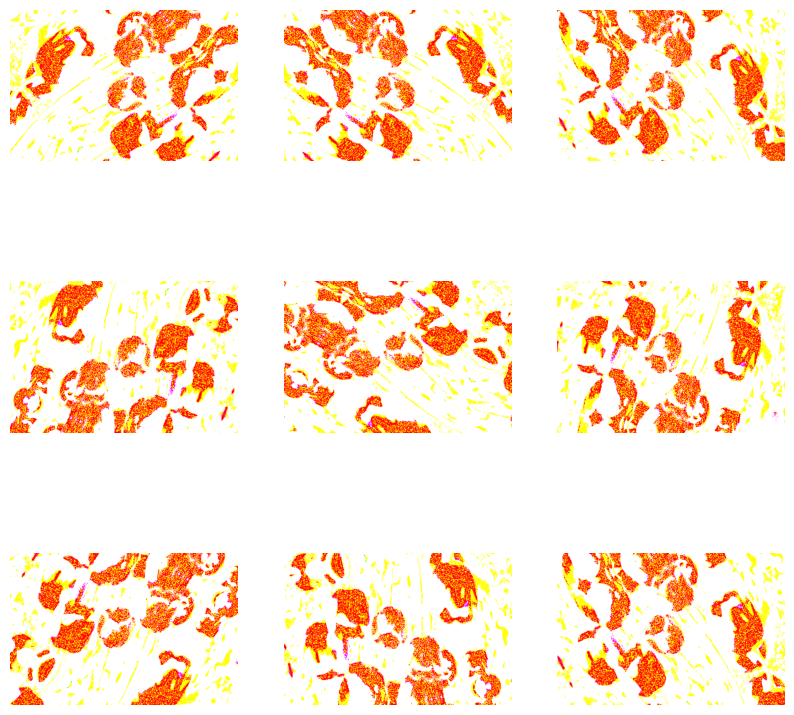

In [11]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

##### Two options to use the Keras preprocessing layers

1. Make the preprocessing layers part of your model

In [12]:
model = tf_keras.Sequential([
    # Add the preprocessing layers you created earlier.
    resize_and_rescale,
    data_augmentation,
    tf_keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf_keras.layers.MaxPooling2D(),
    # Rest of your model.
])

2. Apply the preprocessing layers to your dataset

In [13]:
aug_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
)

### Apply the preprocessing layers to the datasets

In [16]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(
        lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE
    )
    
    if shuffle:
        ds = ds.shuffle(1000)
        
    # Batch all datasets.
    ds = ds.batch(batch_size)
    
    # Use data augmentation only on the training sets.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
        )
    
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
train_ds = prepare(train_ds, shuffle=True, augment=True)

In [18]:
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

In [19]:
model = tf_keras.Sequential([
    tf_keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf_keras.layers.MaxPool2D(),
    tf_keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf_keras.layers.MaxPooling2D(),
    tf_keras.layers.Conv2D(64, 3, padding="same", activation='relu'),
    tf_keras.layers.MaxPool2D(),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(128, activation='relu'),
    tf_keras.layers.Dense(num_classes)
])

In [20]:
model.compile(
    optimizer='adam',
    loss=tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [21]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 21s 195ms/step - loss: 1.3064 - accuracy: 0.4271 - val_loss: 1.1995 - val_accuracy: 0.4578
Epoch 2/5
92/92 [==============================] - 17s 181ms/step - loss: 1.1072 - accuracy: 0.5412 - val_loss: 1.0754 - val_accuracy: 0.5613
Epoch 3/5
92/92 [==============================] - 16s 173ms/step - loss: 1.0277 - accuracy: 0.5841 - val_loss: 1.0307 - val_accuracy: 0.6022
Epoch 4/5
92/92 [==============================] - 21s 228ms/step - loss: 0.9541 - accuracy: 0.6168 - val_loss: 0.9833 - val_accuracy: 0.6049
Epoch 5/5
92/92 [==============================] - 16s 172ms/step - loss: 0.8953 - accuracy: 0.6482 - val_loss: 0.9299 - val_accuracy: 0.6485


In [23]:
loss, acc = model.evaluate(test_ds)
print("Accuracy:", acc)

104/104 [==============================] - 7s 70ms/step - loss: 0.8861 - accuracy: 0.6561
Accuracy: 0.6560702323913574


### Custom data augmentation

In [ ]:
def random_invert_img(x, p=0.5):
    if tf.random.uniform([]) < p:
        x = (255 - x)
    else:
        x
    return x

In [31]:
def random_invert(factor=0.5):
    return tf_keras.layers.Lambda(
        lambda x: random_invert_img(x, factor)
    )

In [32]:
random_invert = random_invert()

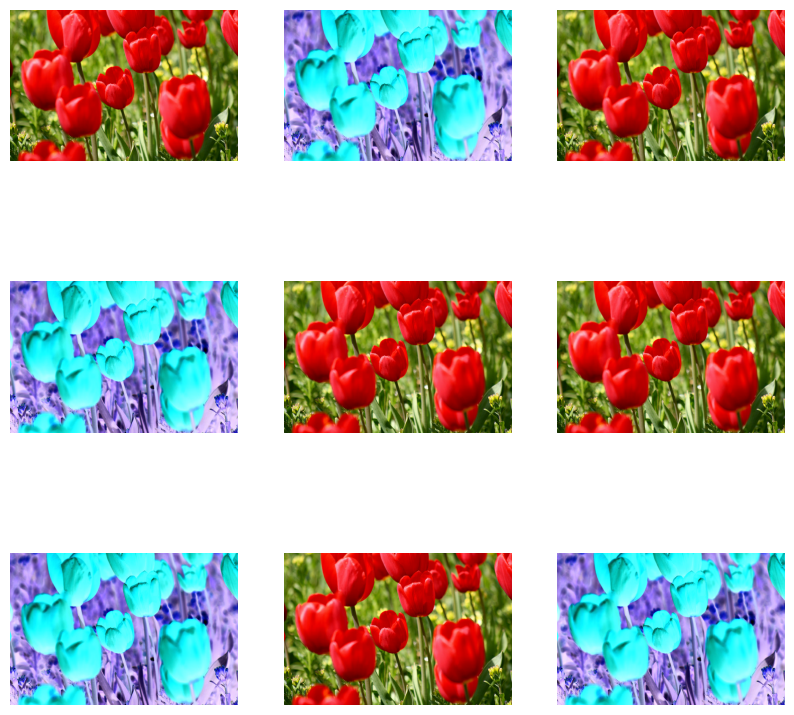

In [33]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis('off')

In [36]:
class RandomInvert(tf_keras.layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
    
    def call(self, x):
        return random_invert_img(x)

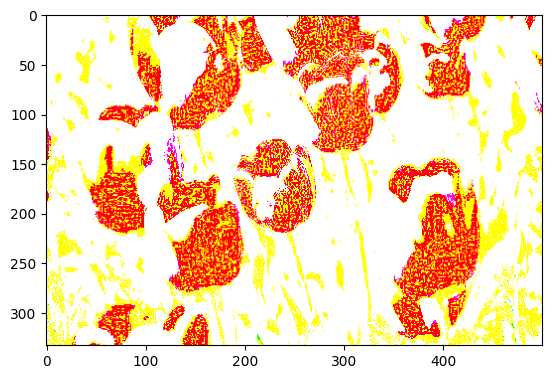

In [37]:
_ = plt.imshow(RandomInvert()(image[0]))

### Using tf.image

In [40]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

2025-04-15 22:15:48.082723: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


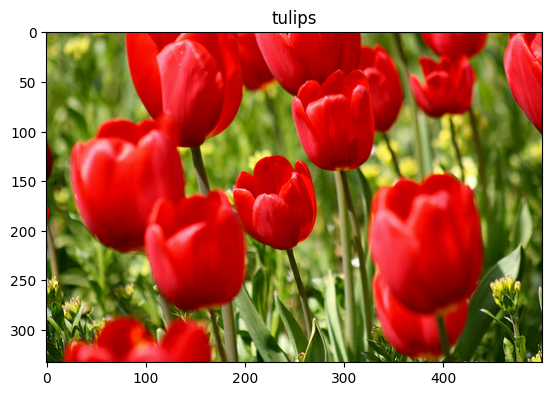

In [41]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [42]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original)
    
    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented)

### Data augmentation

##### Flip an image

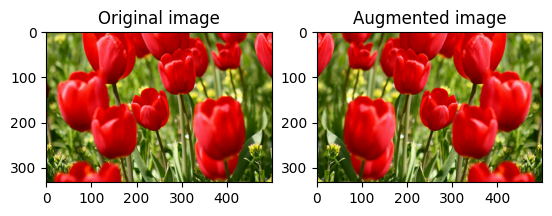

In [43]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

##### Grayscale an image

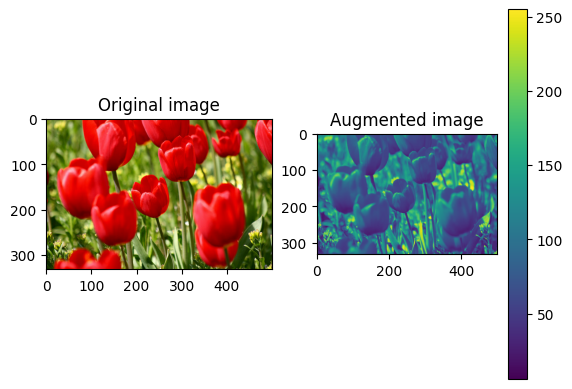

In [44]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

##### Saturate an image

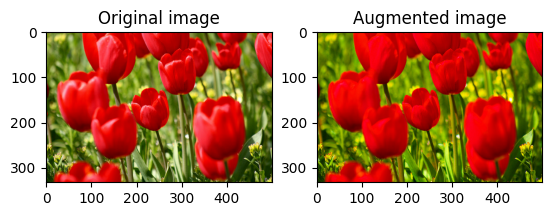

In [45]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

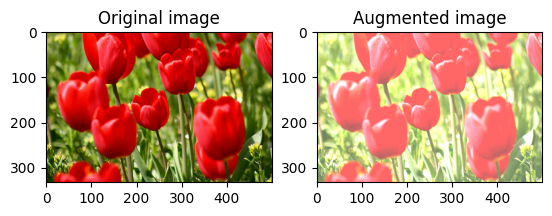

In [46]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

##### Center crop an image


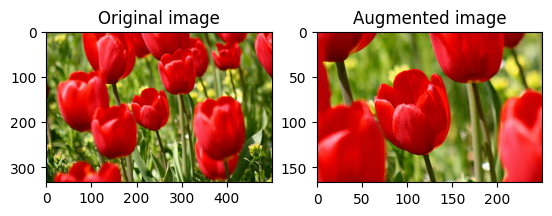

In [49]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

##### Rotate an image

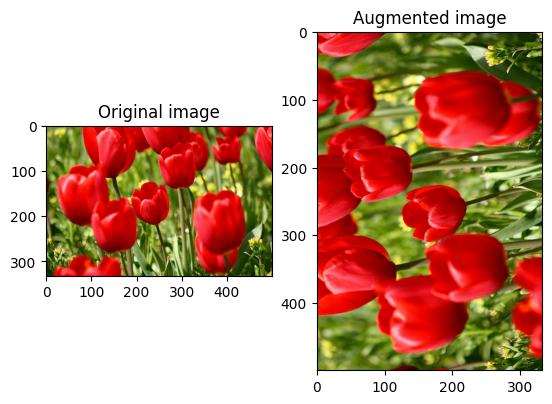

In [50]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

#### Random transformations

##### Randomly change image brightness

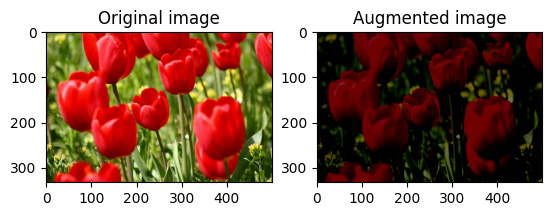

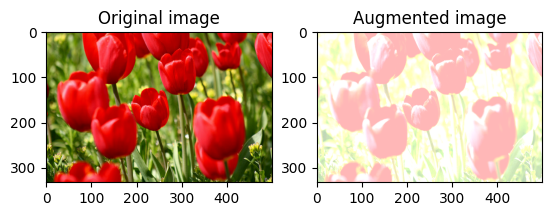

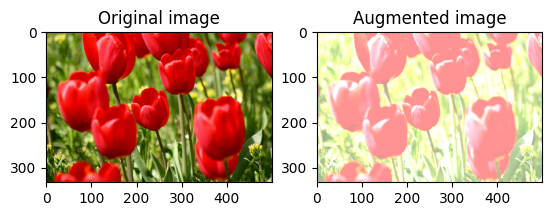

In [52]:
for i in range(3):
    seed = (i, 0)   # tuple of size (2,)
    stateless_random_brightness = tf.image.stateless_random_brightness(
        image, max_delta=0.95, seed=seed
    )
    visualize(image, stateless_random_brightness)

#### Randomly change image contract

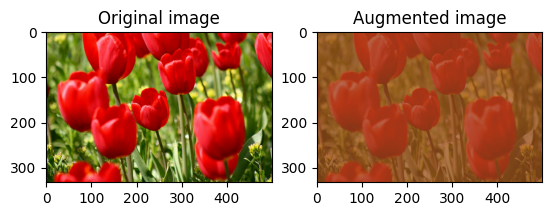

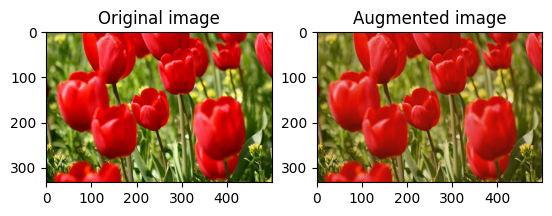

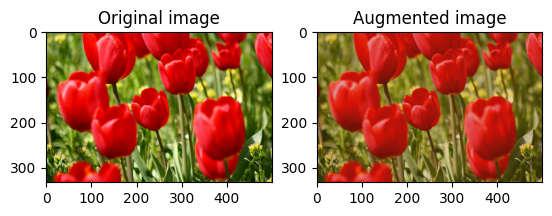

In [54]:
for i in range(3):
    seed = (i, 0)   # tuple of size (2,)
    stateless_random_contrast = tf.image.stateless_random_contrast(
        image, lower=0.1, upper=0.9, seed=seed
    )
    visualize(image, stateless_random_contrast)

#### Randomly crop an image

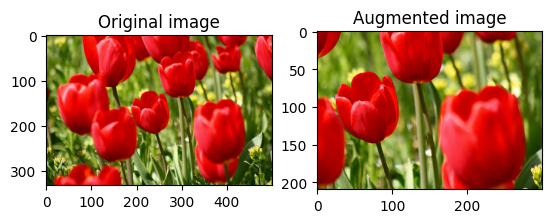

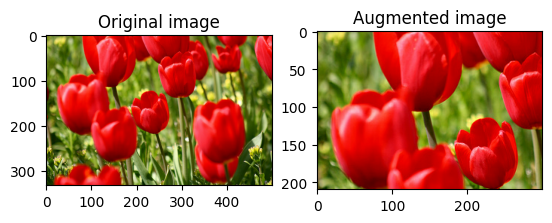

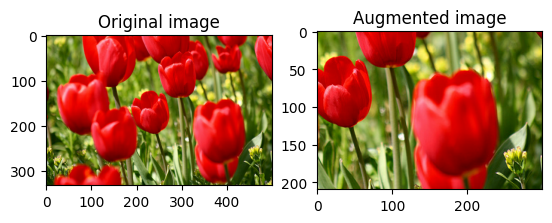

In [55]:
for i in range(3):
    seed = (i, 0)   # tuple of size (2, )
    stateless_random_crop = tf.image.stateless_random_crop(
        image, size=[210, 300, 3], seed=seed
    )
    visualize(image, stateless_random_crop)

### Apply augmentation to a dataset

In [57]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

In [ ]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [59]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Make a new seed.count
    new_seed = tf.random.split(seed, num=1)[0, :]
    image = tf.image.stateless_random_crop(
        image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed
    )
    # Random brightness
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed
    )
    image = tf.clip_by_value(image, 0, 1)
    return image, label